In [22]:
import pandas
import math
import parse
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

#import process
%load_ext Cython

#%%cython
########################################################
evidence_file = 'data/evidence.txt'
filtered_evidence_file = 'data/evidence_filtered.txt'
protein_groups_file = 'data/proteinGroups.txt'
phospho_peptide_file = 'data/Phospho (STY)Sites.txt'
our_group_name = 'PYND'
other_group_names = ['APUBSCRAWL', 'ONION', 'ET0H', 'SHMOO', 'WHANGEE'] # Case doesn't matter

experiment_ext_names = ['Ub', 'UbP', 'WCL', 'WCLP']


########################################################

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [23]:

# Now apply the filter to evidence.txt to get evidence_filtered.tsv
# This should keep only the lines for our group
parse.filter_tsv(evidence_file, filtered_evidence_file, 'Experiment', '^[Pp][Yy][Nn][Dd]')
print('Done.')

Done.


In [24]:
evidence = parse.parse_evidence(filtered_evidence_file)

protein_groups = parse.parse_protein_groups(protein_groups_file)
#protein_groups = parse.remove_cols(protein_groups, other_group_names)

phospho = parse.parse_phosphosites(phospho_peptide_file)
#phospho = parse.remove_cols(phospho, other_group_names)
print("Done.")

/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (421,422) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (211,677,678) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


Done.


In [25]:
def calc_epsilon(protein_groups):
    mins=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                miny=float("inf")
                for x in protein_groups[col]:
                    x = float(x)
                    if x < miny and x != 0.0:
                        miny = x
                if miny != 0.0:
                    mins.append(miny)
    return min(mins)
epsilon = calc_epsilon(protein_groups)
epsilon

6193.8

In [26]:
# What's the distribution of intensities?
def get_intensity_dists(protein_groups, exp_type, cutoff=0):
    intensities=[]
    experiments=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext) and 'KO' in col:
                t = col.split('_')[-1] # to get sorting of keys right
                if t == exp_type:
                    protein_groups = protein_groups[protein_groups[col] > cutoff]
                    protein_groups = protein_groups[protein_groups[col] < float('Inf')]
                    intensities.extend(protein_groups[col])
                    for i in protein_groups[col]:
                        experiments.append(col.split(' ')[1])
    return pandas.DataFrame({"intensity": intensities, "experiment": experiments})

get_intensity_dists(protein_groups.copy(), 'WCL').head()

,experiment,intensity
0,Apubscrawl_Swe1KO_WCL,35874000
1,Apubscrawl_Swe1KO_WCL,6339500
2,Apubscrawl_Swe1KO_WCL,132750000
3,Apubscrawl_Swe1KO_WCL,2717800
4,Apubscrawl_Swe1KO_WCL,4767800


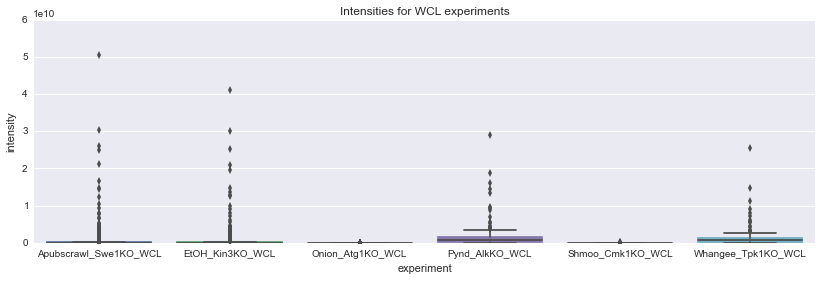

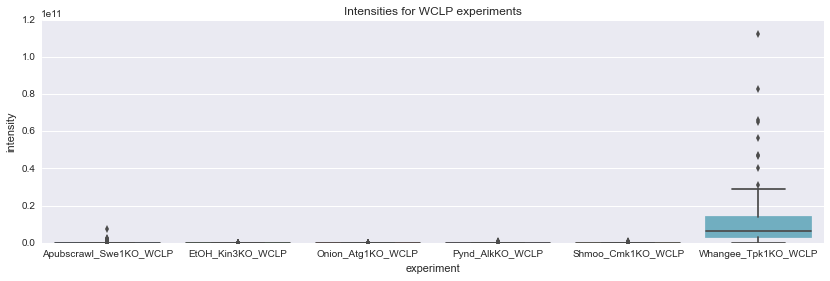

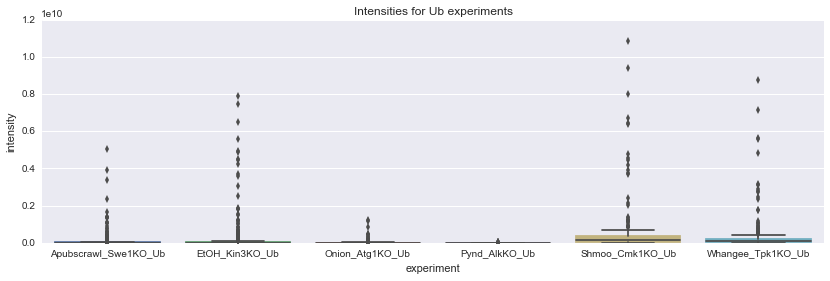

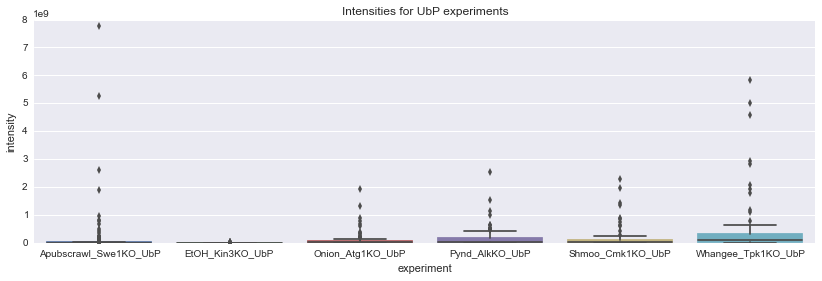

In [27]:
from scipy import stats
sns.set(rc={"figure.figsize": (14, 4)})
def plot_for_exp(exp_type):
    intensities = get_intensity_dists(protein_groups.copy(), exp_type)
    #sns.distplot(intensities['intensity'], kde=False, rug=False, label=exp_type, bins = 40);
    ax = sns.boxplot(x='experiment', y='intensity', data=intensities);
    #sns.axlabel("intensity", "frequency")
    plt.title("Intensities for %s experiments" % exp_type)
    #plt.legend(loc='upper left')
    plt.show()

plot_for_exp('WCL')
plot_for_exp('WCLP')
plot_for_exp('Ub')
plot_for_exp('UbP')

In [46]:
def filter_bad_rows(df):

    def filter_out(prefix):
        return df[df.apply(lambda row: not any([prefix in name for name in row['Protein IDs']]), axis=1)]

    df = filter_out('CON_')
    df = filter_out('REV_')
    return df

def logspace(pg, cols, strict_cutoff=0):
    for col in cols:
        pg = pg[pg[col].map(lambda x: abs(x) > strict_cutoff)]
        pg = pg[pg[col] < float('Inf')]
        pg[col] = pg[col].map(lambda x: math.log(x, 2) if x > epsilon else epsilon)
    return pg

def normalize(pg, top_col, bottom_col, cutoff=10**5):
    pg = pg[pg[top_col] > math.log(cutoff, 2)]
    pg = pg[pg[bottom_col] > math.log(cutoff, 2)]
    pg['diff'] = pg[top_col] - pg[bottom_col]
    return pg

def spaceify(top_col, bottom_col, cutoff=10**5):
    pg = protein_groups.copy()
    pg = filter_bad_rows(pg)
    pg = logspace(pg, [top_col, bottom_col])
    pg = normalize(pg, top_col, bottom_col, cutoff)
    return pg[['Protein IDs', 'Fasta headers', 'diff', top_col, bottom_col]]

def get_top(pg):
    top = pg.sort('diff', 0, False)
    top = top[top['diff'] > math.log(4, 2)]
    return top # .set_index('Protein IDs')
    
def get_bottom(pg):
    bottom = pg.sort('diff', 0, True)
    bottom = bottom[bottom['diff'] < math.log(1/4, 2)]
    return bottom # .set_index('Protein IDs')

print("Done.")

Done.


In [81]:

ko = spaceify('Intensity Pynd_AlkKO_WCL', 'Intensity Control_WCL')
wclp = spaceify('Intensity Pynd_AlkKO_WCLP', 'Intensity Control_WCLP')
ubp = spaceify('Intensity Pynd_AlkKO_UbP', 'Intensity Control_UbP')
fc = spaceify('Intensity Pynd_5FC_Ub', 'Intensity Control_Ub')
print("Done.")

Done.


/Users/student/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


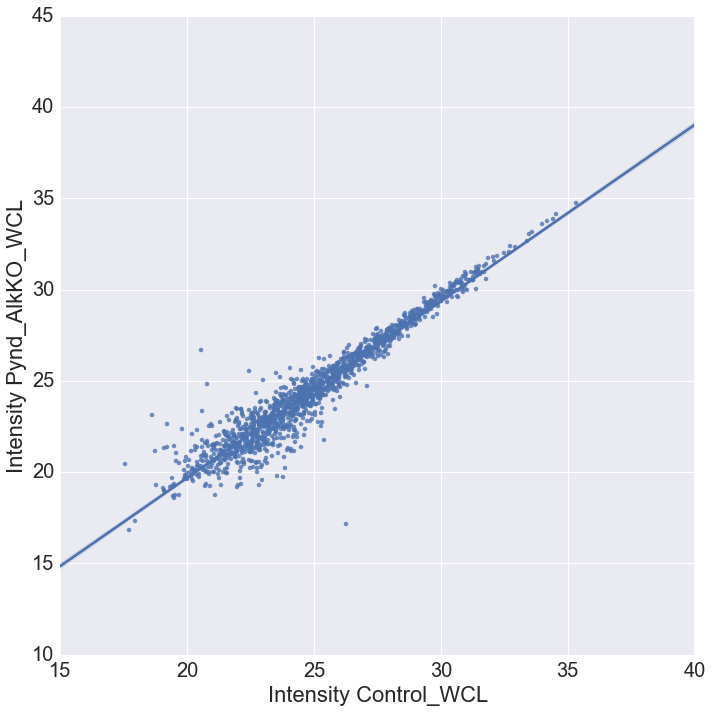

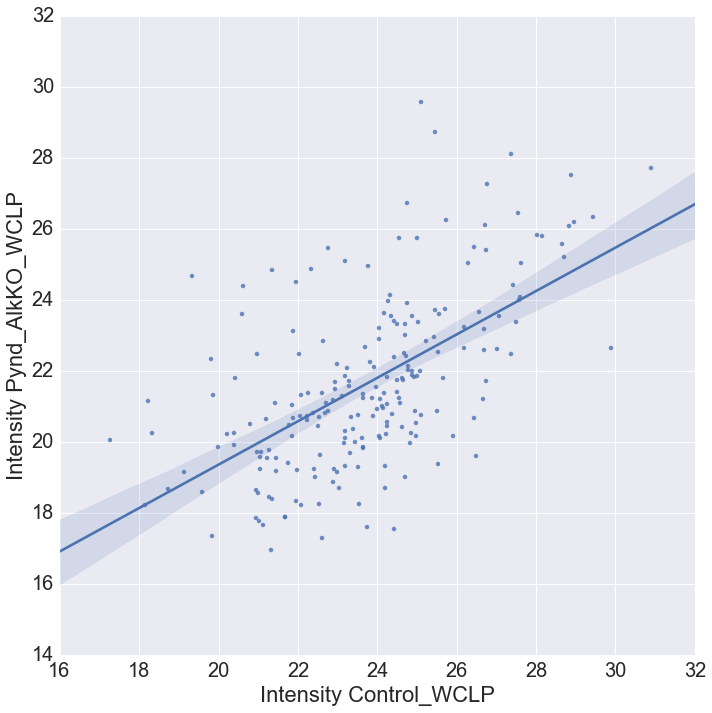

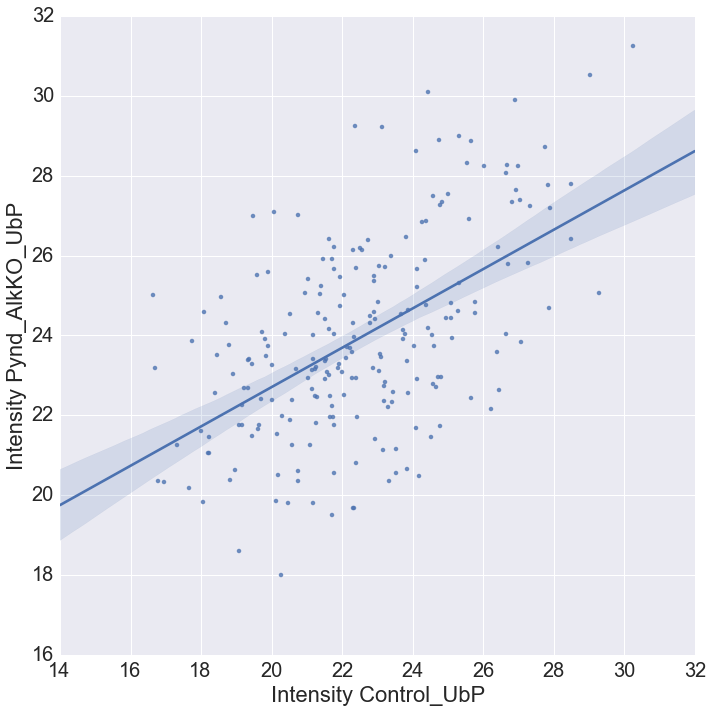

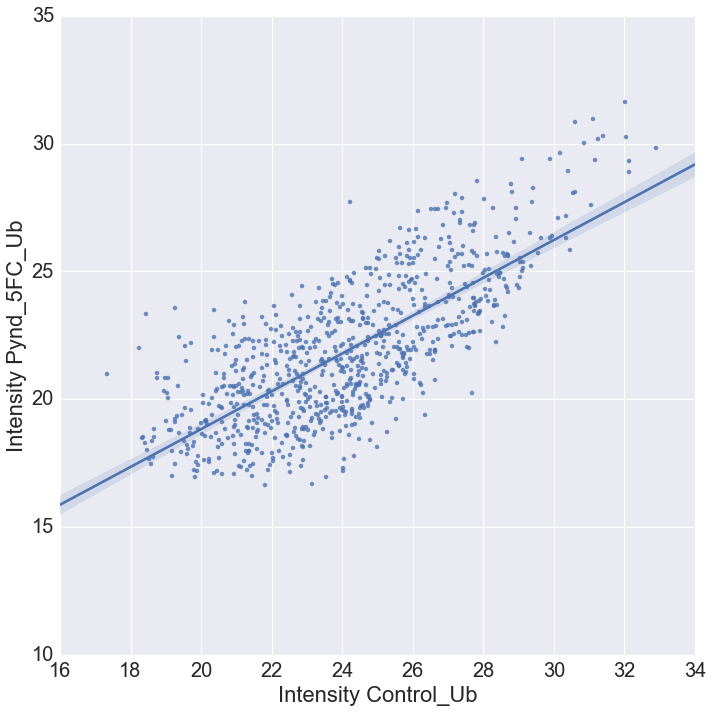

In [47]:

sns.set(rc={"figure.figsize": (12, 8)})
sns.set(font_scale=2)
def analyze(pg, top_col, bottom_col, cutoff=10**5):
    t = get_top(pg)
    b = get_bottom(pg)
    g = sns.lmplot(x=bottom_col, y=top_col, data=pg, size=10); # , y_jitter=.03
    plt.savefig("results/" + top_col + ".png")
    #g.set(xlim=(math.log(epsilon, 2), ))
    #g.set(ylim=(math.log(epsilon, 2), ))
    t.to_csv('results/top_' + top_col + '.csv')
    b.to_csv('results/bottom_' + top_col + '.csv')
    return t, b
    

top_ko, bottom_ko = analyze(ko, 'Intensity Pynd_AlkKO_WCL', 'Intensity Control_WCL')

top_wclp, bottom_wclp = analyze(wclp, 'Intensity Pynd_AlkKO_WCLP', 'Intensity Control_WCLP')

top_ubp, bottom_ubp = analyze(ubp, 'Intensity Pynd_AlkKO_UbP', 'Intensity Control_UbP')

top_5fc, bottom_5fc = analyze(fc, 'Intensity Pynd_5FC_Ub', 'Intensity Control_Ub')

exp_diffs = [ko, wclp, ubp, fc]

In [30]:
#import wget
#wget.download('http://www.geneontology.org/ontology/obo_format_1_2/gene_ontology.1_2.obo')
#print("Done.")

In [32]:
# Let's try using these instead:
# http://www.yeastgenome.org/download-data/curation

id_to_go = {}
for line in open('data/gene_association.sgd', 'r'):
    atoms = line.split()
    if atoms[0] == 'SGD':
        # 1 is the weird yeast ID (SGID), and 6 is the relation:
        # f = function
        # c = compartment
        # p = process
        id_to_go[(atoms[1], atoms[6])] = atoms[3]
len(id_to_go)

64240

In [33]:
import re
pattern = re.compile('SGDID:(S\\d+)')
def get_sgids(lst):
    sgids = []
    for s in lst:
        match = pattern.search(s)
        if match is not None:
            sgids.append(match.group(1))
    return sgids

assert ['S000001611'] == get_sgids(['[>YKL128C PMU1 SGDID:S000001611, Chr XI'])

def get_go_terms(row, rel):
    terms = []
    for sgid in get_sgids(row['Fasta headers']):
        if (sgid, rel) in id_to_go:
            terms.append(id_to_go[(sgid, rel)])
    return terms

print("Done.")

Done.


In [34]:
from goatools import obo_parser
obo = obo_parser.GODag('gene_ontology.1_2.obo')
print("Done.")

load obo file gene_ontology.1_2.obo
45670

Done.


 nodes imported


In [82]:
import random
def add_go_descs(row, rel_long, rel_short, depth=None):
    lst = []
    if depth == None:
        if rel_short == 'C':
            depth = 3
        if rel_short == 'F':
            depth = 2
        if rel_short == 'P':
            depth = 2
    for term in row['GO ' + rel_long]:
        if term in obo:
            o = obo[term]
            while o.depth > depth:
                o = random.choice(o.parents)
            lst.append(o.name)
    return lst

def dedup(df):
    for col in df.columns:
        df[col] = df[col].map(lambda x: (x[0] if len(x) > 0 else None) if type(x) is list else x)
    return df

def show_go(exp_diff):
    exp_diff['GO component'] = exp_diff.apply(lambda row: get_go_terms(row, 'C'), axis=1)
    exp_diff['GO function'] = exp_diff.apply(lambda row: get_go_terms(row, 'F'), axis=1)
    exp_diff['GO process'] = exp_diff.apply(lambda row: get_go_terms(row, 'P'), axis=1)
    #filtered = exp_diff.copy()
    #filtered[filtered['GO'].apply(lambda terms: sum(1 for _ in filter(None, terms)) > 0)]
    exp_diff['GO component description'] = exp_diff.apply(lambda row: add_go_descs(row, 'component', 'C'), axis=1)
    exp_diff['GO function description'] = exp_diff.apply(lambda row: add_go_descs(row, 'function', 'F'), axis=1)
    exp_diff['GO process description'] = exp_diff.apply(lambda row: add_go_descs(row, 'process', 'P'), axis=1)
    return dedup(exp_diff)
    
print("Done.")

Done.


In [83]:
ko = show_go(ko)
wclp = show_go(wclp)
ubp = show_go(ubp)
fc = show_go(fc)
ko.head()

,Protein IDs,Fasta headers,diff,Intensity Pynd_AlkKO_WCL,Intensity Control_WCL,GO component,GO function,GO process,GO component description,GO function description,GO process description
132,YAL003W,">YAL003W EFB1 SGDID:S000000003, Chr I from 142...",-0.643788,30.909421,31.553208,GO:0005853,GO:0005085,GO:1990145,cytoplasmic part,guanyl-nucleotide exchange factor activity,organic substance metabolic process
134,YAL007C,">YAL007C ERP2 SGDID:S000000005, Chr I from 138...",-1.461469,22.780367,24.241836,GO:0030134,GO:0003674,GO:0006888,intracellular organelle,molecular_function,establishment of localization
136,YAL012W,">YAL012W CYS3 SGDID:S000000010, Chr I from 130...",-0.520081,28.201770,28.721852,GO:0005737,GO:0004123,GO:0019344,cytoplasm,lyase activity,organic substance metabolic process
137,YAL016W,">YAL016W TPD3 SGDID:S000000014, Chr I from 124...",-1.952326,20.614951,22.567277,GO:0005934,None,GO:0007094,cellular bud tip,None,regulation of molecular function
139,YAL019W,">YAL019W FUN30 SGDID:S000000017, Chr I from 11...",0.848908,20.515184,19.666276,GO:0031934,GO:0008094,GO:0000729,macromolecular complex,hydrolase activity,cellular metabolic process


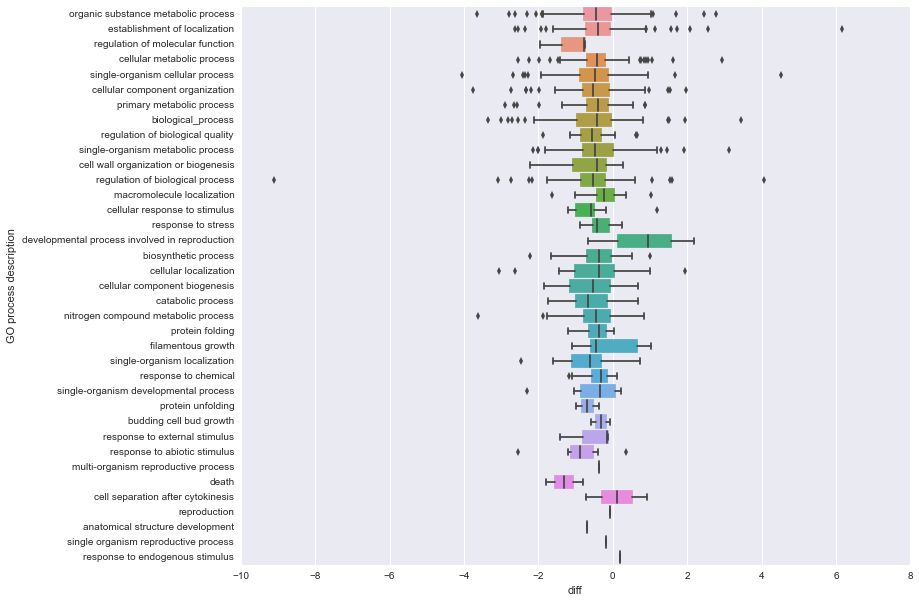

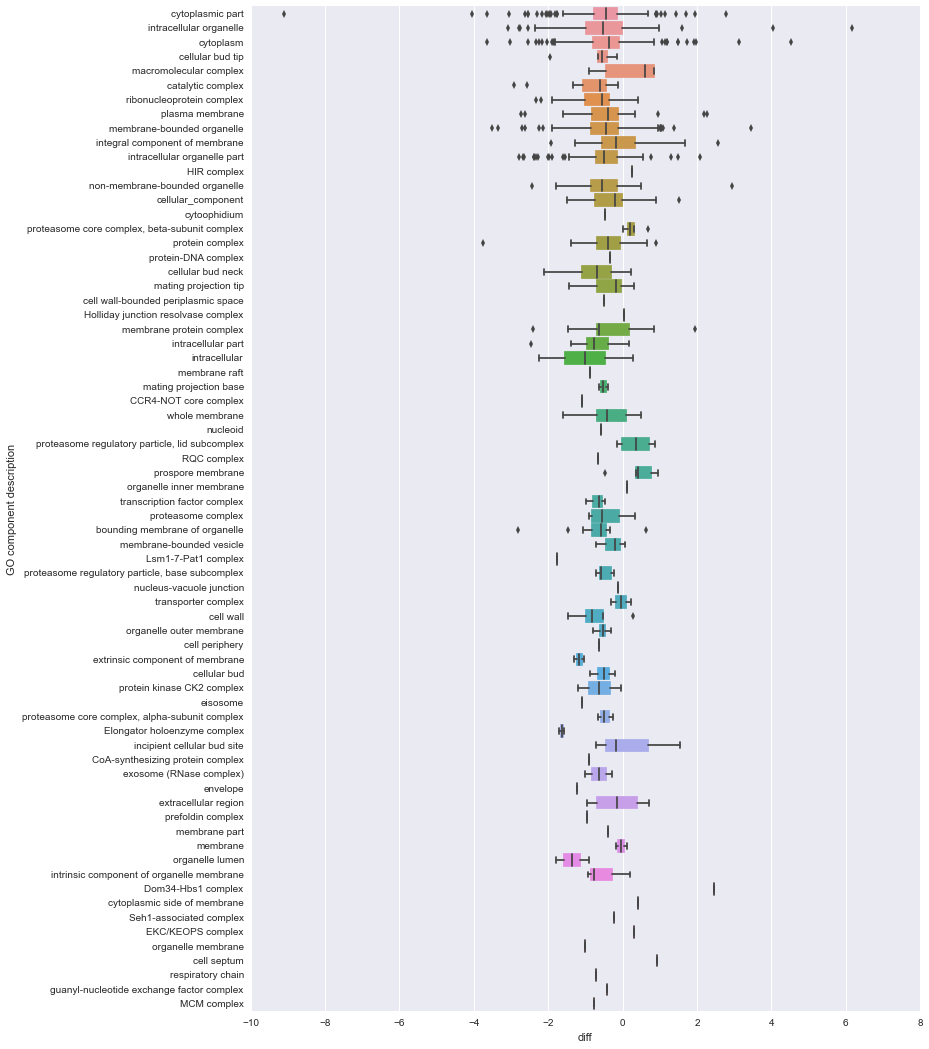

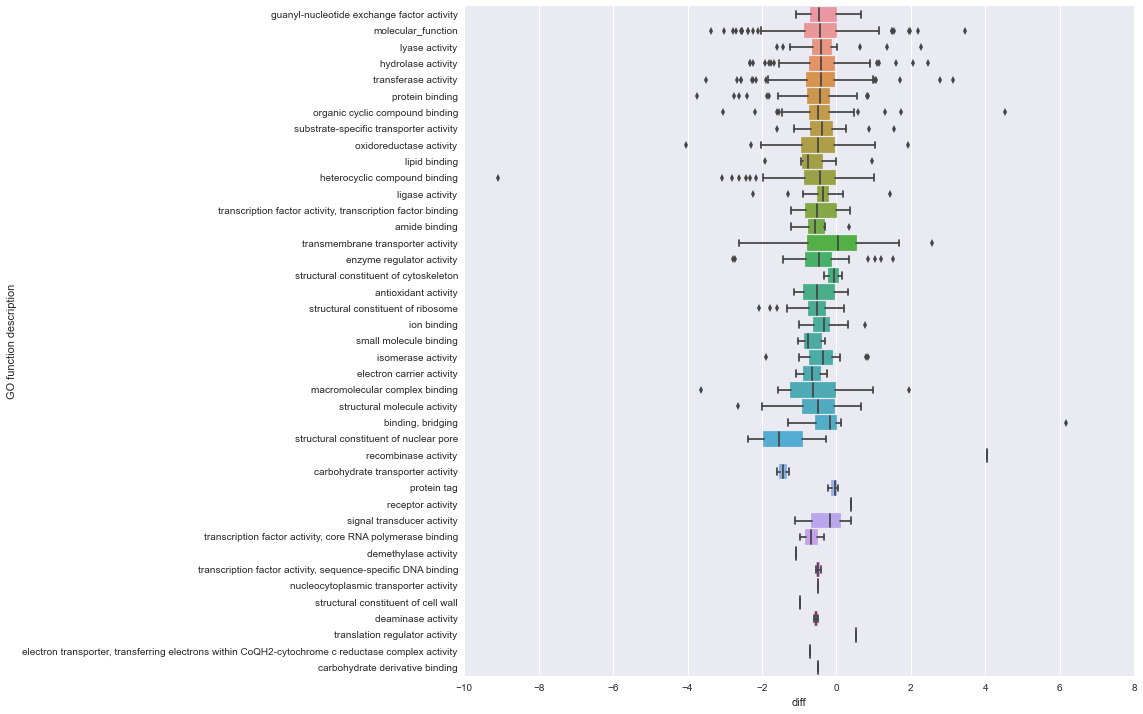

In [89]:
def plot_gos(df, go_type, fig_height):
    sns.set(rc={"figure.figsize": (12, fig_height)})
    #sns.stripplot(y=go_type, x='diff', data=df)
    sns.boxplot(y=go_type, x='diff', data=df)
    #sns.set(font_scale=2)
    #sns.plt.xlim(min(df[time]),)
    plt.show()
    
plot_gos(ko, 'GO process description', 10)
plot_gos(ko, 'GO component description', 18)
plot_gos(ko, 'GO function description', 12)

In [18]:
def denormalize(df):
    rows_list = []
    for index, row in df.iterrows():
        for i in range(0, len(row[0])):
            dct = {}
            for j in range(0, len(df.columns)):
                #if not dct[df.columns[j]].startswith('GO'):
                dct[df.columns[j]] = row[j]
            print(row)
            dct['Protein ID'] = row['Protein IDs'][i]
            dct['Fasta header'] = row['Fasta headers'][i]
            dct['GO components'] = row['GO components'][i]
            dct['GO functions'] = row['GO functions'][i]
            dct['GO processes'] = row['GO processes'][i]
            #dct['GO component descriptions'] = row[8][i]
            #dct['GO function descriptions'] = row[9][i]
            #dct['GO process descriptions'] = row[10][i]
            #del dct['Fasta headers']
            #del dct['Protein IDs']
            rows_list.append(dct)
        #for i in range(0, len(row)):
        #    dct[df.columns[i]] = row[i]
        #for i in range(0, len(dict['Protein IDs'])):
        #    print("HI")
        #for i in range(0, len(row['Protein IDs'])):
    return pandas.DataFrame(rows_list)
        
#denormalize(ko)
#ko.columns

In [101]:
top_ko['Fasta headers']

1416    [>YIL022W TIM44 SGDID:S000001284, Chr IX from ...
915     [>YER088C DOT6 SGDID:S000000890, Chr V from 33...
710     [>YDR296W MHR1 SGDID:S000002704, Chr IV from 1...
1737    [>YKL128C PMU1 SGDID:S000001611, Chr XI from 2...
1672    [>YJR148W BAT2 SGDID:S000003909, Chr X from 70...
2376    [>YNL147W LSM7 SGDID:S000005091, Chr XIV from ...
1946    [>YLR195C NMT1 SGDID:S000004185, Chr XII from ...
2142    [>YML123C PHO84 SGDID:S000004592, Chr XIII fro...
1824    [>YKR084C HBS1 SGDID:S000001792, Chr XI from 5...
1507    [>YJL005W CYR1 SGDID:S000003542, Chr X from 42...
560     [>YDL223C HBT1 SGDID:S000002382, Chr IV from 6...
2900    [>YPR024W YME1 SGDID:S000006228, Chr XVI from ...
Name: Fasta headers, dtype: object

In [106]:
# GO enrichment
with open('results/ko_top_sgdids.txt', 'w') as f:
    for k in top_ko['Fasta headers']:
        f.write("%s\n" % get_sgids(k)[0])
        
with open('results/ko_bottom_sgdids.txt', 'w') as f:
    for k in bottom_ko['Fasta headers']:
        f.write("%s\n" % get_sgids(k)[0])
        
with open('results/ko_sgdids.txt', 'w') as f:
    for k in ko['Fasta headers']:
        f.write("%s\n" % get_sgids([k])[0])
        
print("Done.")

Done.
